**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist.models import StarDist3D

np.random.seed(6)
# lbl_cmap = random_label_cmap()

import zarr
# import napari

from cupyx.scipy import ndimage
import cupy as cp

import dask.array as da

# next round normalization based on cells
from skimage.measure import regionprops, regionprops_table
from skimage.transform import rescale

import pandas as pd

from scipy import interpolate
from scipy.spatial import Delaunay
from scipy.spatial import KDTree

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
SCRIPT_DIR = '/home/tmurakami/src/pylsfm/pylsfm'
sys.path.append(os.path.dirname(SCRIPT_DIR))

import pylsfm.morphology
import pylsfm.utils

In [2]:
# load zarr
#moved_path = '/mnt/ampa_data01/tmurakami/220310_0004_R01/ch561.zarr'
#moved_path = '/mnt/ampa_data01/tmurakami/220321_0004_R02/ch561.zarr'
#moved_path = '/mnt/ampa_data01/tmurakami/220329_0004_R03/ch640.zarr'
mask_path = '/mnt/ampa_data01/tmurakami/220310_0004_R01/ch488.zarr'
mask_zarr = zarr.open(mask_path, mode='r')

moved_path = '/mnt/ampa_data01/tmurakami/220310_0004_R01/ch785.zarr'
moved_zarr = zarr.open(moved_path, mode='r')

outprefix = '/mnt/ampa_data01/tmurakami/220310_0004_R01/R01_R01/R01ch785_to_R01_segmentation'
if not os.path.isdir(outprefix):
    os.makedirs(outprefix)

img_s = mask_zarr['4'][:] # for mask
img_zarr = moved_zarr['0']

# convert zarr to dask
img = da.from_zarr(img_zarr)


In [3]:
# rechunk and generate overlaps for analysis
total_overlap = (40,40,40)
inner_overlap = (20,20,20)
chunk_size = (512,512,512)
img = da.rechunk(img,chunks=chunk_size)
img_overlap = da.overlap.overlap(img,depth=total_overlap,boundary=0)

In [4]:
# make mask
img_mask = pylsfm.morphology.mask_maker(img_s,500)

# visualize the mask if necessary
# viewer = napari.Viewer()
# viewer.add_image(img_s, contrast_limits=[0,10000], rgb=False, colormap='green', blending='additive')
# viewer.add_image(img_mask, contrast_limits=[0,5], rgb=False, colormap='magenta', blending='additive')

In [5]:
# get chunk size and shape of fixed.
target_chunk_size = pylsfm.utils.chunks_from_dask(img)
target_shape = img.shape
# get chunk size of fixed with overlaps
overlap_chunk_size = pylsfm.utils.chunks_from_dask(img_overlap)

# make flag array from masks
flag_array = pylsfm.utils.flag_array_generator(target_chunk_size, target_shape, img_mask)
print(f'{flag_array.sum()} blocks of {flag_array.shape[0]}*{flag_array.shape[1]}*{flag_array.shape[2]}={flag_array.size} blocks will be calculated')
print(f'overlap chunk size: {overlap_chunk_size}, target chunk size: {target_chunk_size}')

634 blocks of 4*17*17=1156 blocks will be calculated
overlap chunk size: (592, 592, 592), target chunk size: (512, 512, 512)


In [6]:
def get_slicers_with_chunkidx(da_array, index):
    chunk_info = da_array.chunks
    p = slice(sum(chunk_info[0][:index[0]]),sum(chunk_info[0][:index[0]])+chunk_info[0][index[0]]) 
    q = slice(sum(chunk_info[1][:index[1]]),sum(chunk_info[1][:index[1]])+chunk_info[1][index[1]])
    r = slice(sum(chunk_info[2][:index[2]]),sum(chunk_info[2][:index[2]])+chunk_info[2][index[2]])
    
    return p, q, r

In [7]:
def slicing_with_chunkidx(da_array, index):
    chunk_info = da_array.chunks
    p = slice(sum(chunk_info[0][:index[0]]),sum(chunk_info[0][:index[0]])+chunk_info[0][index[0]]) 
    q = slice(sum(chunk_info[1][:index[1]]),sum(chunk_info[1][:index[1]])+chunk_info[1][index[1]])
    r = slice(sum(chunk_info[2][:index[2]]),sum(chunk_info[2][:index[2]])+chunk_info[2][index[2]])
    
    return da_array[p, q, r]

In [8]:
def get_cellular_intensity_interpolator(labels, image):
    props = pd.DataFrame(regionprops_table(labels, intensity_image=image, properties=('label','centroid','intensity_max')))
    coords = props.loc[:,['centroid-0','centroid-1','centroid-2']].round().to_numpy().astype(int)
    intensity_max = props.loc[:,['intensity_max']].to_numpy().flatten()
    
    # fill the values in 8 cornerr by referring the nearest cell.
    shape = image.shape
    edge_coords = np.asarray([
        [0,0,0],
        [shape[0]-1,0,0],
        [0,shape[1]-1,0],
        [0,0,shape[2]-1],
        [shape[0]-1,shape[1]-1,0],
        [shape[0]-1,0,shape[2]-1],
        [0,shape[1]-1,shape[2]-1],
        [shape[0]-1,shape[1]-1,shape[2]-1]
    ])
    # use kdtree to get nearest cell
    tree = KDTree(coords)
    edge_intensity = intensity_max[tree.query(edge_coords)[1]]
    # re-organize coords and intensity_max by adding corners.
    coords = np.vstack([coords,edge_coords]) 
    intensity_max = np.hstack([intensity_max,edge_intensity]) 

    # make interpolator. 
    # to boost interpolation
    # https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids
    # https://stackoverflow.com/questions/51858194/storing-the-weights-used-by-scipy-griddata-for-re-use/51937990#51937990
    tri = Delaunay(coords)
    interpolator = interpolate.LinearNDInterpolator(tri, intensity_max)
    
    return interpolator

In [9]:
def local_max_with_interpolator(interpolator, shape):
    z = np.linspace(0, shape[0]-1, shape[0])
    y = np.linspace(0, shape[1]-1, shape[1])
    x = np.linspace(0, shape[2]-1, shape[2])
    zg, yg ,xg = np.meshgrid(z, y, x, indexing='ij', sparse=True)
    local_max = interpolator((zg,yg,xg))
    
    return local_max

In [10]:
# set parameters for initial normalization.
footprint=np.ones((1,5,100))
high_percentile = 99
low_percentile = 1

# set parameters for second normalization
upper_clip = 2.0
lower_clip = -1.0

# following is to keep memory of GPU
img_raw_cp = cp.asarray(slicing_with_chunkidx(img_overlap, (0,0,0)))
img_high = ndimage.percentile_filter(img_raw_cp,high_percentile,footprint=footprint)
img_low = ndimage.percentile_filter(img_raw_cp,low_percentile,footprint=footprint)

### load trained model
model = StarDist3D(None, name='stardist', basedir='models_08_plp1')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.561232, nms_thresh=0.3.


2022-06-04 10:14:39.211419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-04 10:14:40.155325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37176 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [11]:
# get the shapes and chunks of the outputs
inner_overlapped_chunks = img_high.get()[tuple([slice((i-j),-(i-j)) for i,j in zip(total_overlap,inner_overlap)])].shape
inner_overlapped_shape = tuple([int(len(i))*j for i, j in zip(img_overlap.chunks,inner_overlapped_chunks)])
inner_overlapped_prob_chunks = tuple([i//2 for i in inner_overlapped_chunks])
inner_overlapped_prob_shape = tuple([int(len(i))*j for i, j in zip(img_overlap.chunks,inner_overlapped_prob_chunks)])

In [12]:
# prepare zarr to save the overlapped output.
# Set zarr path for registered moving image.
save_segmented = True
if save_segmented:
    segmented_zarr = zarr.open(
        os.path.join(outprefix, 'segmented_overlap.zarr'), 
        mode='w-', 
        shape=inner_overlapped_shape, 
        chunks=inner_overlapped_chunks, 
        dtype=np.int32
    )
else:
    segmented_zarr = None

# Set zarr path for displacement map.
save_probability = True
if save_probability:
    probability_zarr = zarr.open(
        os.path.join(outprefix, 'probability_overlap.zarr'), 
        mode='w-', 
        shape=inner_overlapped_prob_shape, 
        chunks=inner_overlapped_prob_chunks, 
        dtype=np.float32
    )
else:
    probability_zarr = None

In [13]:
for i in range(flag_array.shape[0]):
    for j in range(flag_array.shape[1]):
        for k in range(flag_array.shape[2]):
            if flag_array[i,j,k]:
                # convert dask array to numpy
                img_raw = slicing_with_chunkidx(img_overlap, (i,j,k)).compute()

                # GPU percentile normalization
                img_raw_cp = cp.asarray(img_raw)
                img_high = ndimage.percentile_filter(img_raw_cp,high_percentile,footprint=footprint)
                img_low = ndimage.percentile_filter(img_raw_cp,low_percentile,footprint=footprint)
                img_norm_pre = (img_raw.astype(float) - img_low.get()) / (img_high.get() - img_low.get())
                img_norm_pre[np.isnan(img_norm_pre)] = 0 # convert nan to 0

                # initial segmentation. this is for better local normalization.
                pre_labels, _ = model.predict_instances(img_norm_pre, n_tiles=(2,2,2), show_tile_progress=False)
                
                if pre_labels.sum() != 0:
                    # make normalized image based on cellular intensity
                    interpolator = get_cellular_intensity_interpolator(pre_labels, img_raw)
                    local_max = local_max_with_interpolator(interpolator,img_raw.shape)
                    img_norm = (img_raw.astype(float) - img_low.get()) / (local_max - img_low.get())
                    img_norm[np.isnan(img_norm)] = 0 # convert nan to 0

                    # clip the normalized image
                    img_norm[img_norm>upper_clip]=upper_clip
                    img_norm[img_norm<lower_clip]=lower_clip

                    # actual segmentation
                    labels, details = model.predict_instances(img_norm, n_tiles=(2,2,2), show_tile_progress=False, return_predict=True)

                    # trim the edge of the overlap. do it in both label and probability
                    labels = labels[0][tuple([slice((i-j),-(i-j)) for i,j in zip(total_overlap,inner_overlap)])]
                    prob = details[0][tuple([slice((i-j)//2,-(i-j)//2) for i,j in zip(total_overlap,inner_overlap)])]

                    # save to zarr
                    slicer = get_slicers_with_chunkidx(da.from_zarr(segmented_zarr), (i,j,k))
                    segmented_zarr[slicer] = labels

                    slicer = get_slicers_with_chunkidx(da.from_zarr(probability_zarr), (i,j,k))
                    probability_zarr[slicer] = prob

3325043286.py (12): invalid value encountered in true_divide
2022-06-04 10:14:51.644538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-06-04 10:14:55.854377: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
base.py (680): Setting sparse to False because return_predict is True
3325043286.py (12): invalid value encountered in true_divide
base.py (680): Setting sparse to False because return_predict is True
3325043286.py (12): divide by zero encountered in true_divide
3325043286.py (12): invalid value encountered in true_divide
base.py (680): Setting sparse to False because return_predict is True
3325043286.py (12): invalid value encountered in true_divide
base.py (680): Setting sparse to False because return_predict is True
3325043286.py (12): inval

In [14]:
### visualizers

In [25]:
# viewer = napari.Viewer()
#viewer.add_image(img_raw, rgb=False, name='original_image' , colormap='gray' ,blending='additive')
#iewer.add_image(img_norm, rgb=False, name='image_norm2' , colormap='gray' ,blending='additive')
#viewer.add_labels(labels)
# viewer.add_image(rescale(details[0],2,preserve_range=True), rgb=False, name='prob' , colormap='gray' ,blending='additive')

<Labels layer 'Labels' at 0x7f165a84c490>

In [44]:
# save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R03_640.tif', img_raw, axes='ZYX')
# save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R03_640_model04.tif', labels2, axes='ZYX')
# save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_prob.tif', rescale(details2[0],2,preserve_range=True), axes='ZYX')

__init__.py (40): Converting data type from 'int32' to ImageJ-compatible 'int16'.


In [61]:
#

In [22]:
prob_ref = imread('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R02_561_prob.tif')
prob = imread('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_prob.tif')

In [43]:
props = pd.DataFrame(regionprops_table(labels2[0],intensity_image=prob_ref*prob,properties=('label','intensity_max','intensity_mean')))

In [36]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

-3.025661791172103


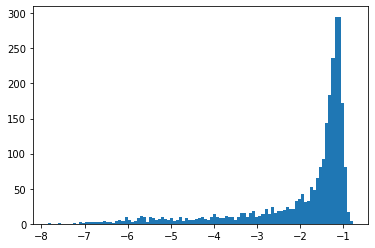

In [44]:
mean_joint_prob = props['intensity_mean'].to_numpy()
plt.hist(np.log10(mean_joint_prob),bins=100)
print(threshold_otsu(np.log10(mean_joint_prob)))
thresh = threshold_otsu(np.log10(mean_joint_prob))

In [50]:
filtered_ids = props['label'][np.log10(mean_joint_prob)>=bools].to_numpy()
filtered_labels = labels2[0] * np.isin(labels2[0],filtered_ids)

In [51]:
save_tiff_imagej_compatible('/mnt/ampa_data01/tmurakami/conf_proc/whole_brain_seg/manual_check/R01_561_model04_filtered.tif', filtered_labels, axes='ZYX')

__init__.py (40): Converting data type from 'int32' to ImageJ-compatible 'int16'.
